## Import dependencies
- pandas
- numpy
- matplotlib
- scipy
- scikit-learn
- fastcluster

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from fastcluster import linkage
from matplotlib.colors import ListedColormap
import time
from tqdm import tqdm
import math
import pickle as pkl
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Create merch dictionary to map merch number and merch name

In [3]:
def read_main(main_path):  
    merch = {}
    main_data = pd.read_csv(main_path, sep="\t")
    for x in range(main_data.shape[0]):
        merch[main_data.iloc[x]["商品代號"]] = main_data.iloc[x]["商品名稱"]
    print(len(merch))
    return merch, main_data
merch, main_data = read_main('../../data/main.txt')

4535


## Create whole_sales matrix from csv

In [4]:
whole_sales = pd.read_csv('../../data/銷售數量2017_transformed.csv', sep=",")

In [5]:
# groups refers to 群番 in the whole_sales table
groups = whole_sales['商品代號'].map(lambda num: int(num/10000)).to_numpy()

## Create whole_purchases matrix from csv

In [6]:
whole_purchases = pd.read_csv('../../data/訂貨進貨2017_transformed.csv', sep=",")

## Create whole_storages matrix from csv

In [7]:
whole_storages = pd.read_csv('../../data/庫存數量2017_transformed.csv', sep=",")

## Create whole_discards matrix from csv

In [8]:
whole_discards = pd.read_csv('../../data/廢棄數量2017_transformed.csv', sep=",")

In [9]:
joined = pd.merge(whole_sales, whole_purchases, how='left', on=['原始店號', '商品代號'])

In [10]:
joined = pd.merge(joined, whole_storages, how='left', on=['原始店號', '商品代號'])

In [11]:
joined = pd.merge(joined, whole_discards, how='left', on=['原始店號', '商品代號']).to_numpy()

## Delete merchs that have too few data points

In [12]:
def del_too_small(joined, groups, min_thres):
    temp_sales = joined[:, 2:367].astype(np.int64)
    joined = np.delete(joined, np.where(np.sum(temp_sales,axis=1)<min_thres)[0], axis=0)
    groups = np.delete(groups, np.where(np.sum(temp_sales,axis=1)<min_thres)[0], axis=0)
    return joined, groups
joined, groups = del_too_small(joined, groups, min_thres)
print(joined.shape)
print(groups.shape)

(5992, 1462)
(5992,)


In [13]:
sales = joined[:, 2:367].astype(np.int64)
purchases = joined[:,367:732]
storages =  np.nan_to_num(joined[:, 732:1097]).astype(np.float64)
discards = joined[:, 1097:].astype(np.float64)
new_purchases = []
for x in range(purchases.shape[0]):
    new_purchases.append([])
    for y in purchases[x]:
        new_purchases[x].append(int(y.split('/')[-1]))
purchases = np.array(new_purchases).astype(np.int64)
del new_purchases
del joined

## Define global variables

In [33]:
# merchs that have total sales lower than the min_thres are discarded
min_thres = 20
# filename to load in or save the similarity matrix
sim_filename = 'sim_matrix_'+str(min_thres)
# number of total merchs
N = sales.shape[0]

## Compute vec_angles as similarity matrix using cosine

In [14]:
def to_cos_sim(sales):
    sales_trans = sales.T
    sales_length = np.sqrt(np.sum(sales**2, axis=1)).reshape((sales.shape[0],1))
    sales_lengths = np.dot(sales_length, sales_length.T)
    vec_angles = np.dot(sales,sales_trans)/sales_lengths
    vec_angles = np.nan_to_num(vec_angles, posinf=0)
    for x in range(vec_angles.shape[0]):
        vec_angles[x,x] = 1.0
    return vec_angles

vec_angles = to_cos_sim(sales)

 ## Compute vec_angles as similarity matrix considering purchases

In [15]:
def get_sim(sales, purchases):
    curr_time = time.time()
    print("Start time:", curr_time)
    sales_trans = sales.T
    mask = np.logical_or((sales>0), (purchases>0))
    print(mask.shape)
    sim = np.dot(sales, sales_trans)
    print("Time to process dot product:", time.time()-curr_time,"secs")
    curr_time = time.time()
    length_product = np.zeros(sim.shape)
    for i in tqdm(range(sim.shape[0])):
        for j in range(sim.shape[1]):
            length_product[i][j] = (np.sqrt(np.sum((mask[i]*sales[j])**2))*np.sqrt(np.sum((mask[j]*sales[i])**2)))
    print("Time to calculate length products:", time.time()-curr_time, "secs")
    sim = sim/length_product
    
    return sim
# sim = get_sim(sales, purchases)

In [18]:
def save_sim(filename):
    fileObject = open(filename, 'wb')
    pkl.dump(sim, fileObject)
    fileObject.close()
# save_sim(sim_filename)

In [20]:
def load_sim(filename):
    fileObject = open(filename, 'rb')
    sim = pkl.load(fileObject)
    fileObject.close()
    sim = np.nan_to_num(sim, posinf=0)
    for x in range(sim.shape[0]):
        sim[x,x] = 1.0
    return sim
# sim = load_sim(sim_filename)
# sim[sim<0] = 0

## Function for plotting two vectors

In [21]:
def plot_2vec(idx1, idx2, data=sales, purchases=purchases, storages=storages, discards=discards):
    print("First merch:", whole_sales.iloc[idx1]["商品代號"])
    print("Second merch:", whole_sales.iloc[idx2]["商品代號"])
    fontsize = 15
    x = range(365)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(15,30))
    
    ax1.scatter(x, data[idx1], s=10, c='b', marker="s", label=whole_sales.iloc[idx1]["商品代號"])
    ax1.scatter(x, data[idx2], s=10, c='r', marker="o", label=whole_sales.iloc[idx2]["商品代號"])
    ax1.set_xlabel('day', fontsize = fontsize)
    ax1.set_ylabel('amount', fontsize = fontsize)
    ax1.set_title('Sales', fontsize = fontsize)
    
    ax2.scatter(x, purchases[idx1], s=10, c='b', marker="s", label=whole_sales.iloc[idx1]["商品代號"])
    ax2.scatter(x, purchases[idx2], s=10, c='r', marker="o", label=whole_sales.iloc[idx2]["商品代號"])
    ax2.set_xlabel('day', fontsize = fontsize)
    ax2.set_ylabel('amount', fontsize = fontsize)
    ax2.set_title('Purchases', fontsize = fontsize)
    
    ax3.scatter(x, purchases[idx1]-data[idx1], s=10, c='b', marker="s", label=whole_sales.iloc[idx1]["商品代號"])
    ax3.scatter(x, purchases[idx2]-data[idx2], s=10, c='r', marker="o", label=whole_sales.iloc[idx2]["商品代號"])
    ax3.set_xlabel('day', fontsize = fontsize)
    ax3.set_ylabel('amount', fontsize = fontsize)
    ax3.set_title('Purchases - Sales', fontsize = fontsize)
    
    ax4.scatter(x, discards[idx1], s=10, c='b', marker="s", label=whole_sales.iloc[idx1]["商品代號"])
    ax4.scatter(x, discards[idx2], s=10, c='r', marker="o", label=whole_sales.iloc[idx2]["商品代號"])
    ax4.set_xlabel('day', fontsize = fontsize)
    ax4.set_ylabel('amount', fontsize = fontsize)
    ax4.set_title('Discards', fontsize = fontsize)
    
    ax5.scatter(x, storages[idx1], s=10, c='b', marker="s", label=whole_sales.iloc[idx1]["商品代號"])
    ax5.scatter(x, storages[idx2], s=10, c='r', marker="o", label=whole_sales.iloc[idx2]["商品代號"])
    ax5.set_xlabel('day', fontsize = fontsize)
    ax5.set_ylabel('amount', fontsize = fontsize)
    ax5.set_title('Storages', fontsize = fontsize)
    
    ax6.scatter(x[:-1], np.diff(storages[idx1])-purchases[idx1,1:]+data[idx1,1:]+discards[idx1,1:], s=10, c='b', marker="s", label=whole_sales.iloc[idx1]["商品代號"])
    ax6.scatter(x[:-1], np.diff(storages[idx2])-purchases[idx2,1:]+data[idx2,1:]+discards[idx2,1:], s=10, c='r', marker="o", label=whole_sales.iloc[idx2]["商品代號"])
    ax6.set_xlabel('day', fontsize = fontsize)
    ax6.set_ylabel('amount', fontsize = fontsize)
    ax6.set_title('delta_Storages - Purchases + Sales + Discards', fontsize = fontsize)

    fig.tight_layout()
    plt.show()

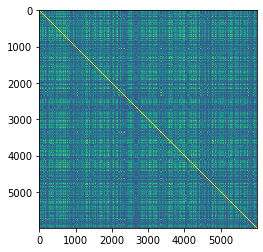

In [22]:
plt.imshow(vec_angles)

## Get similar merchs for each row given a similarity threshold

In [24]:
def get_similars(sim, thres, sales):
    similars = []
    for i in range(sales.shape[0]):
        similars.append(np.where(sim[i]>=thres)[0])
    return similars
similars = get_similars(vec_angles, 1, sales)

## Create dictionary for mapping row number to merch name

In [25]:
row2merch = {}
for row in range(sales.shape[0]):
    row2merch[row] = merch[whole_sales.iloc[row]["商品代號"]]

In [26]:
def show_similars(similars):
    for s in range(len(similars)):
        print(s, end=' ')
        for row in similars[s]:
            print(row, row2merch[row], end=' ')
        print('\n')
# show_similars(similars)

First merch: 1060234
Second merch: 650218


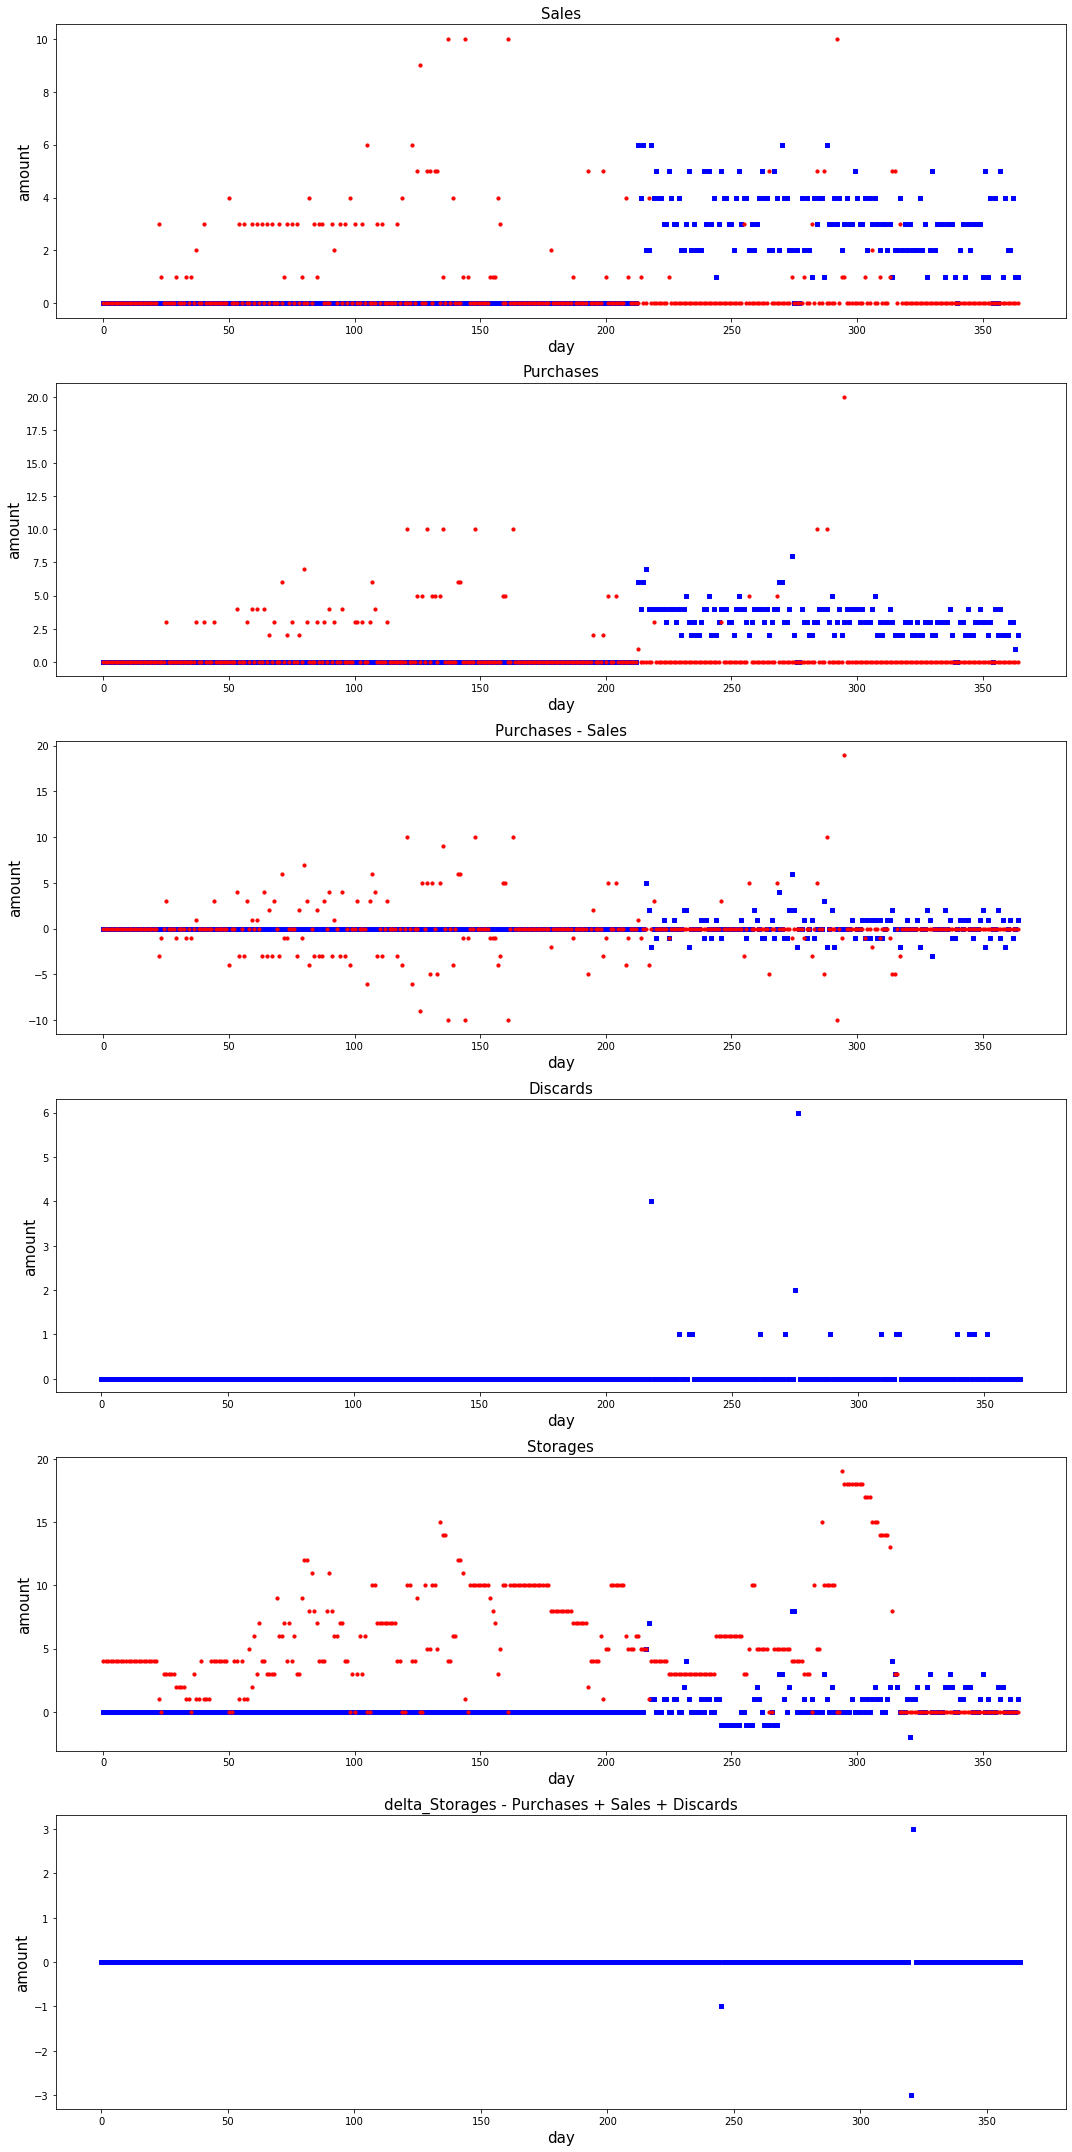

In [27]:
plot_2vec(114, 3384)

## Compute distance matrix from similarity matrix for hierarchical clustering

In [28]:
dist_mat = 1-vec_angles

## Functions for hierarchical clustering

In [29]:
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))

In [30]:
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

## Compute hierarchical clustering with 3 methods
- ward
- complete
- average

Method:	 ward


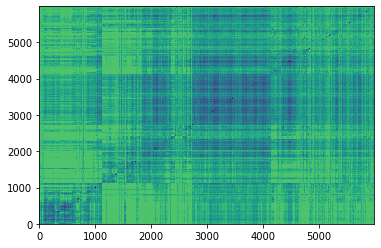

In [34]:
method = "ward"

print("Method:\t",method)

ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,method)

plt.pcolormesh(ordered_dist_mat)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

Method:	 complete


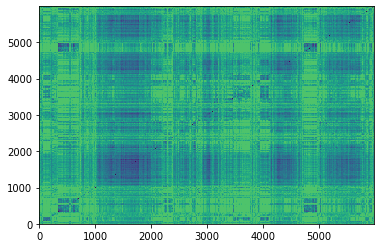

In [35]:
method = "complete"

print("Method:\t",method)

ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,method)

plt.pcolormesh(ordered_dist_mat)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

### The "average" method has the best clustering result on the vec_angles similarity

Method:	 average


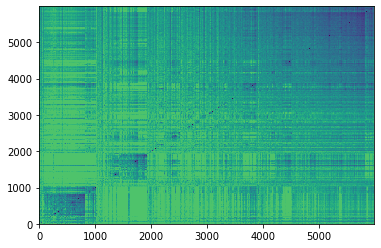

In [36]:
method = "average"


print("Method:\t",method)

ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,method)

plt.pcolormesh(ordered_dist_mat)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

## Compute Laplacian Matrix and plot its eigenvalues
Reference: https://www.quora.com/Whats-the-intuition-behind-a-Laplacian-matrix-Im-not-so-much-interested-in-mathematical-details-or-technical-applications-Im-trying-to-grasp-what-a-laplacian-matrix-actually-represents-and-what-aspects-of-a-graph-it-makes-accessible

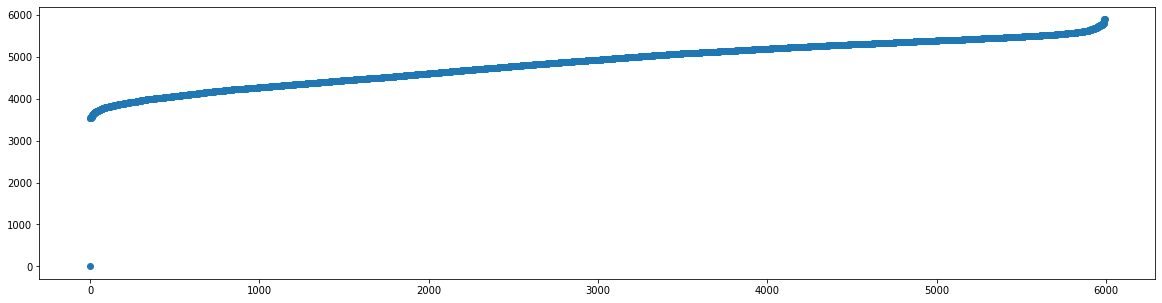

In [38]:
def Laplacian_EigVal(ordered_dist_mat):
    D = np.zeros((ordered_dist_mat.shape[0],ordered_dist_mat.shape[0]))
    for x in range(ordered_dist_mat.shape[0]):
        D[x,x] = np.sum(ordered_dist_mat[x])
    L = D-ordered_dist_mat
    # eigenvalues and eigenvectors
    vals, vecs = np.linalg.eig(L)

    # sort these based on the eigenvalues
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    x = np.array(range(vals.shape[0]))
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(111)
    ax1.scatter(x,vals)
    plt.show()
    return vecs, vals
vecs, vals = Laplacian_EigVal(ordered_dist_mat)

In [39]:
print(vals[:10])

[-2.21579076e-12  3.52985567e+03  3.53124299e+03  3.53374611e+03
  3.54754299e+03  3.54962437e+03  3.55058419e+03  3.55470839e+03
  3.56009585e+03  3.57036715e+03]


## Perform KMeans specifying n_clusters

In [40]:
from sklearn.cluster import KMeans
n_clusters = 15
init = np.transpose(vecs[:,:n_clusters])
kmeans = KMeans(n_clusters=n_clusters, init=init)
kmeans.fit(ordered_dist_mat)
# colors holds the categories Kmeans predicted
colors = kmeans.labels_

/Users/hsureggie/coding/python/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


## Color ordered_dist_mat with cluster information

In [41]:
unique_groups, group_indices = np.unique(groups, return_inverse=True)
print(unique_groups.shape)

(92,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


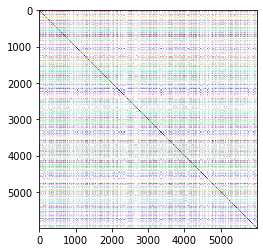

In [42]:
def Create_new_map(ordered_dist_mat, colors, n_clusters):
    new_map = []
    rand_colors = np.random.rand(n_clusters,3)
    count = 0
    for x in range(ordered_dist_mat.shape[0]):
        group_color = rand_colors[colors[x] -1]
        group_color = np.repeat(group_color, ordered_dist_mat.shape[1]).reshape((3,ordered_dist_mat.shape[1])).T
        temp = np.reshape(ordered_dist_mat[x],(ordered_dist_mat[x].shape[0], 1))
        group_color = np.concatenate((group_color, temp), axis=1)
        new_map.append(group_color)
    new_map = np.array(new_map)
    plt.imshow(new_map)
    plt.show()
    return new_map

new_map = Create_new_map(vec_angles, group_indices, unique_groups.shape[0])


## Plot by group_names (群番)

92


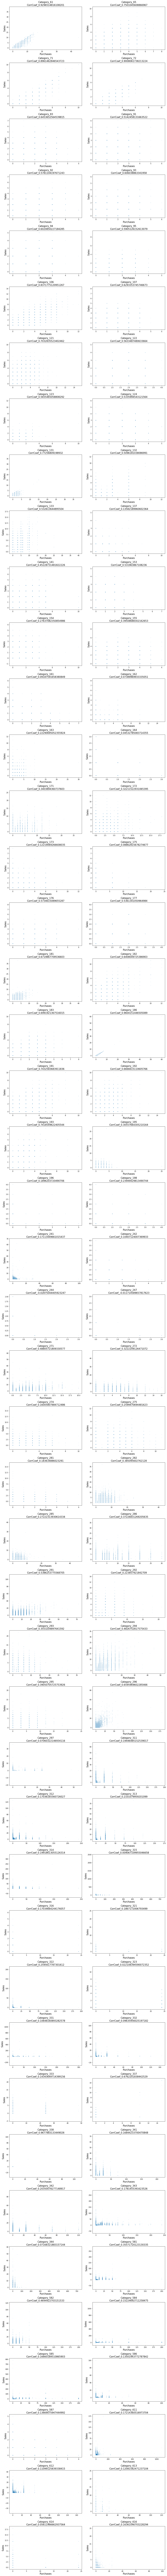

In [43]:
# If group_names is not None, group_names is a map to 群番
def show_category_plots(n_clusters, colors, sales, purchases, group_names=None):
    fig, ax_list = plt.subplots(nrows=math.ceil(n_clusters/2), ncols=2, figsize=(15,5*math.ceil(n_clusters/2)))
    fontsize = 15
    corrcoefs = []
    for x in range(n_clusters):
        cat = set()
        for y in range(len(colors)):
            if colors[y] == x:
                cat.add(y)
        cat_sales = []
        cat_purchases = []
        for elem in cat:
            for z in range(sales[elem].shape[0]):
                cat_sales.append(sales[elem][z])
                cat_purchases.append(purchases[elem][z])
        corrcoef = np.corrcoef(cat_sales, cat_purchases)[1,0]
        corrcoefs.append(corrcoef)
        ax = ax_list[math.floor(x/2)][x%2]
        ax.scatter(cat_purchases,cat_sales, s=4, alpha=0.1)
        ax.set_xlabel('Purchases', fontsize = fontsize)
        ax.set_ylabel('Sales', fontsize = fontsize)
        if group_names is not None:
            ax.set_title('Category_'+str(group_names[x])+'\nCorrCoef_'+str(corrcoef), fontsize = fontsize)
        else:
            ax.set_title('Category_'+str(x)+'\nCorrCoef_'+str(corrcoef), fontsize = fontsize)
    fig.tight_layout()
    plt.show()
    return corrcoef

n_clusters = unique_groups.shape[0]
print(n_clusters)
corrcoefs = show_category_plots(n_clusters, group_indices, sales, purchases, unique_groups)

## Plot by clusters predicted by KMeans

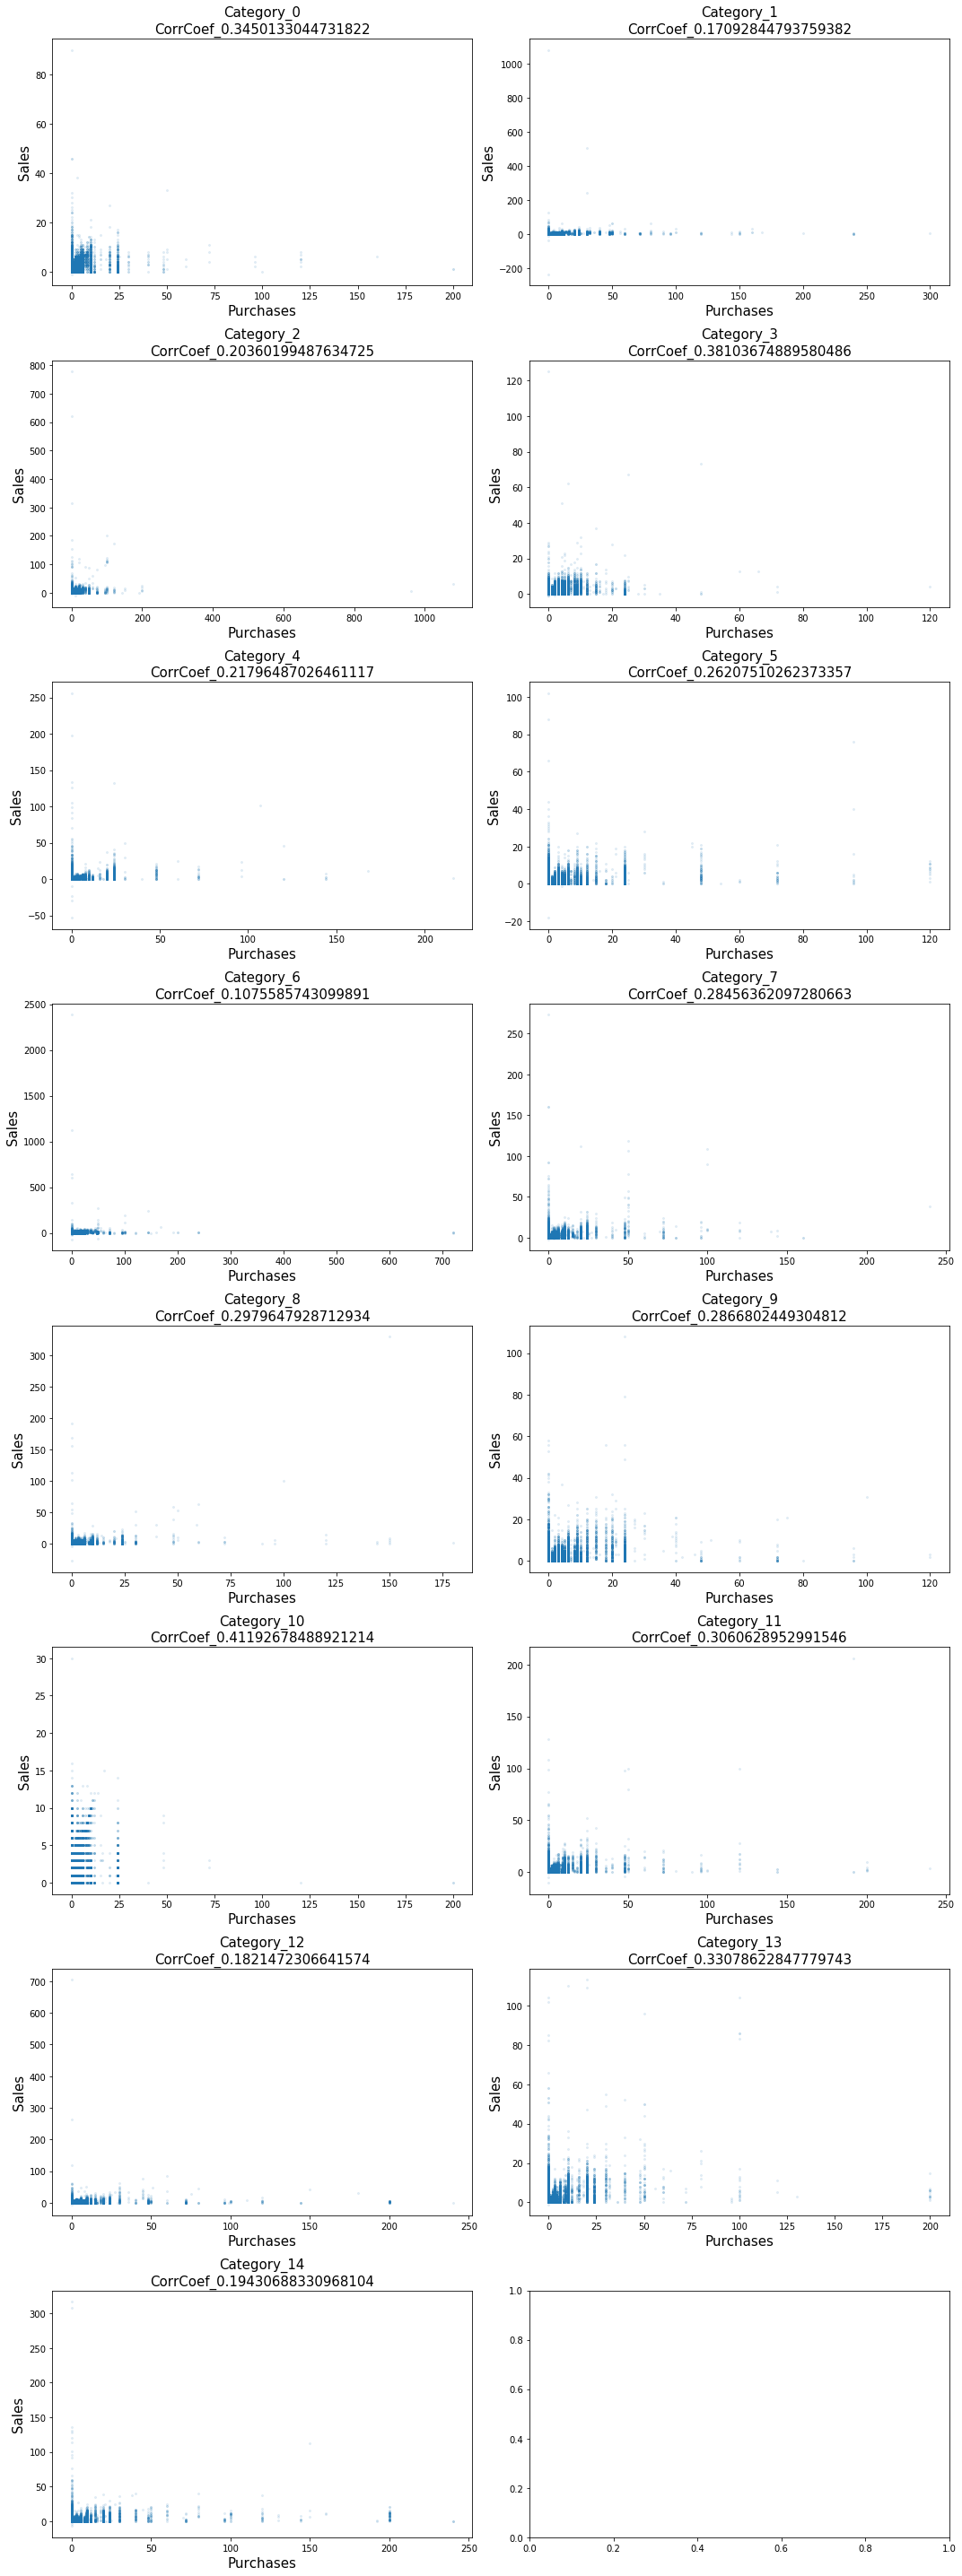

In [44]:
n_clusters = 15
self_cluster_coefs = show_category_plots(n_clusters, colors, sales, purchases)

In [45]:
# Uncomment the following line to see merchs in a group(群番)
# main_data[main_data['群番'] == 612]